In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


weather_data = pd.read_csv(r"C:\Users\PC\Desktop\istanbul 2023-12-31 to 2024-12-31.csv")
viewing_data = pd.read_csv(r"C:\Users\PC\Desktop\ViewingActivity.csv")


weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
weather_data['weather_category'] = weather_data['conditions']  # Keep the detailed conditions


min_temp = int(np.floor(weather_data['temp'].min()))
max_temp = int(np.ceil(weather_data['temp'].max()))


bins = list(range(min_temp, max_temp + 5, 5))
labels = [f"{bins[i]} to {bins[i+1]}" for i in range(len(bins) - 1)]
weather_data['temp_interval'] = pd.cut(weather_data['temp'], bins=bins, labels=labels, right=False)


viewing_data['Start Time'] = pd.to_datetime(viewing_data['Start Time'])
viewing_data['date'] = viewing_data['Start Time'].dt.date
viewing_data['duration_minutes'] = viewing_data['Duration'].apply(
    lambda x: sum(int(t) * 60**i for i, t in enumerate(reversed(x.split(":"))))
)


weather_data['date'] = weather_data['datetime'].dt.date
merged_data = pd.merge(viewing_data, weather_data[['date', 'weather_category', 'temp_interval', 'temp']], on='date', how='inner')

Creating the data frame

The data frame is created from the ViewingActivity.csv that I downloaded by e-mail from Netflix and weather data is from the website of VisualCrossing. 
Processed both data set and merged them based on date for further analysis.


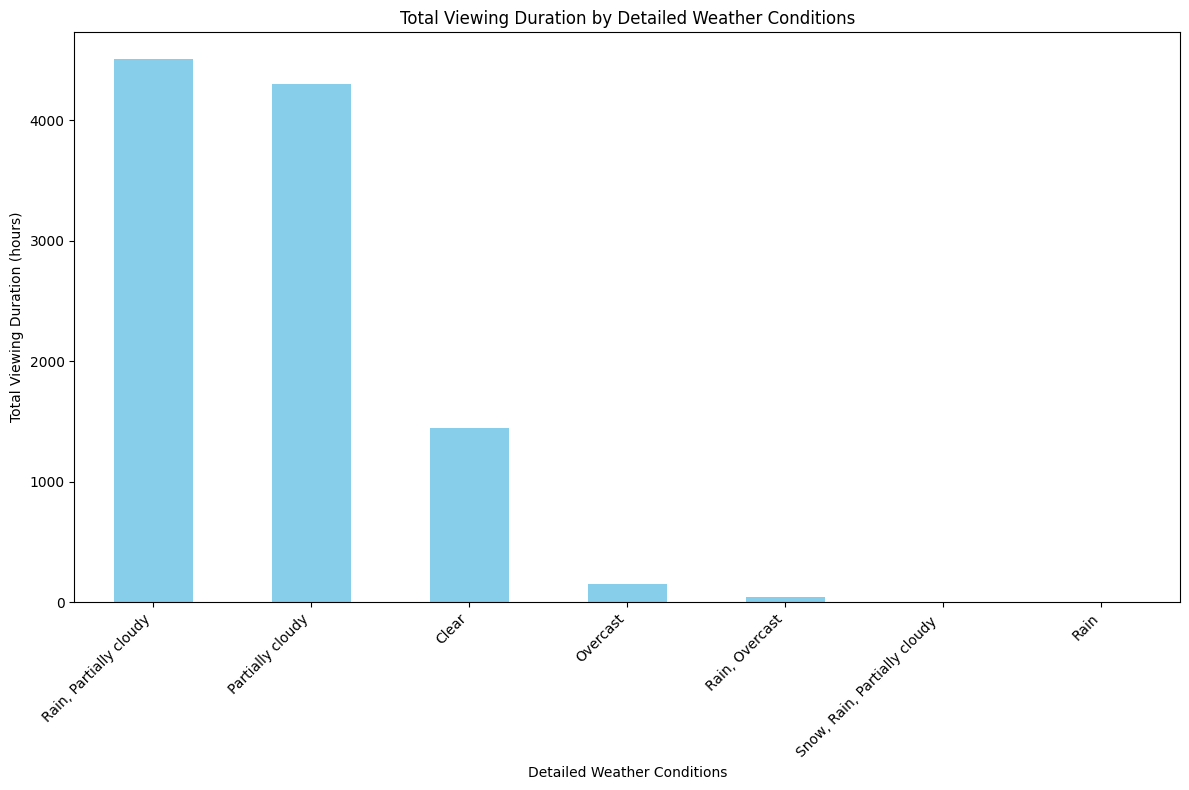

In [44]:

all_weather_categories = ['Rain', 'Snow, Rain, Partially cloudy ', 'Clear', 'Overcast', 'Partially cloudy', 'Rain, Overcast', 'Rain, Partially cloudy']


detailed_watching_by_weather = merged_data.groupby('weather_category')['duration_minutes'].sum() / 60


detailed_watching_by_weather = detailed_watching_by_weather.reindex(all_weather_categories, fill_value=0)


plt.figure(figsize=(12, 8))
detailed_watching_by_weather.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Total Viewing Duration by Detailed Weather Conditions')
plt.ylabel('Total Viewing Duration (hours)')
plt.xlabel('Detailed Weather Conditions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This bar chart is trying to answer the question  "How did weather conditions effect my viewing duration". By looking at that chart we can say that there is agglomeration on Rain and Partially Cloudy.

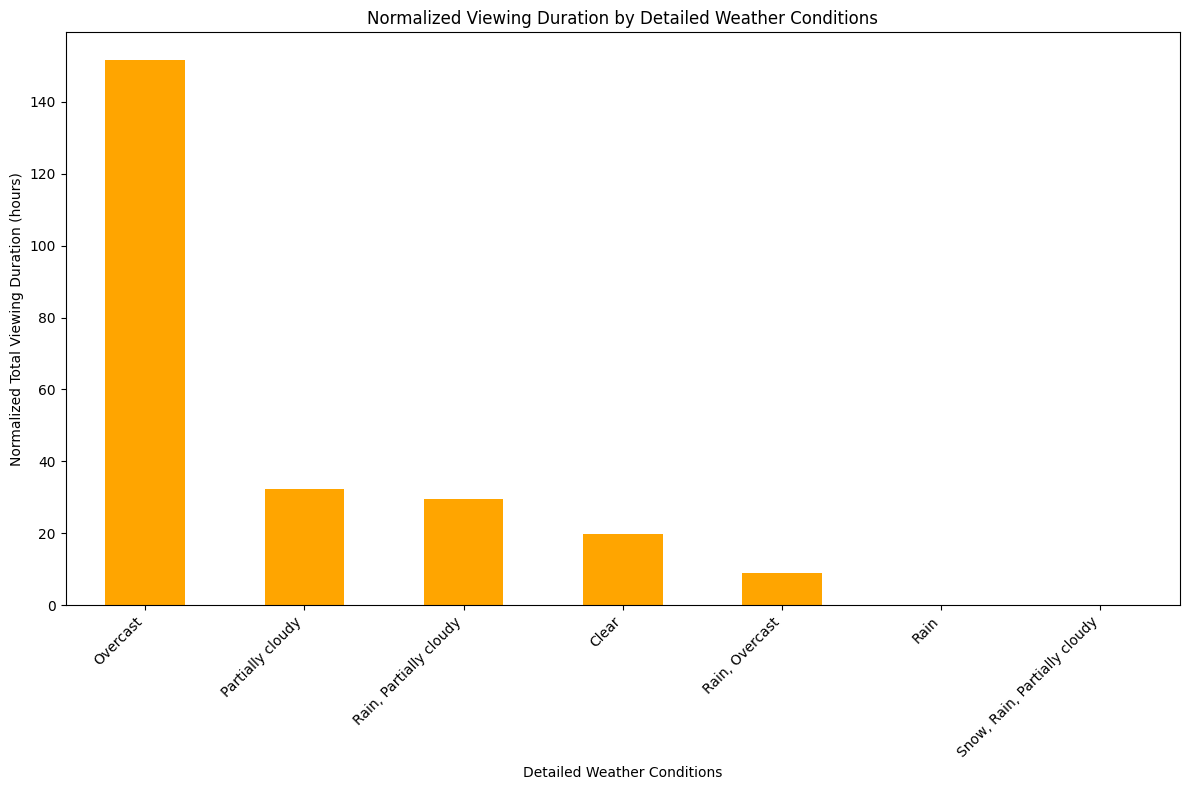

In [45]:
days_per_condition = weather_data['weather_category'].value_counts()
normalized_weather = (merged_data.groupby('weather_category')['duration_minutes'].sum() / 60) / weather_data['weather_category'].value_counts()


# Plot normalized viewing duration by weather condition
plt.figure(figsize=(12, 8))
normalized_weather.sort_values(ascending=False).plot(kind='bar', color='orange')
plt.title('Normalized Viewing Duration by Detailed Weather Conditions')
plt.ylabel('Normalized Total Viewing Duration (hours)')
plt.xlabel('Detailed Weather Conditions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The agglomeration occured since the data set was not normally distributed after the needed normalizations are done overcast dominated the chart as I expected since I love being outside  if weather is good.

C:\Users\PC\AppData\Local\Temp\ipykernel_31060\748173662.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  watching_by_temp = merged_data.groupby('temp_interval')['duration_minutes'].sum() / 60


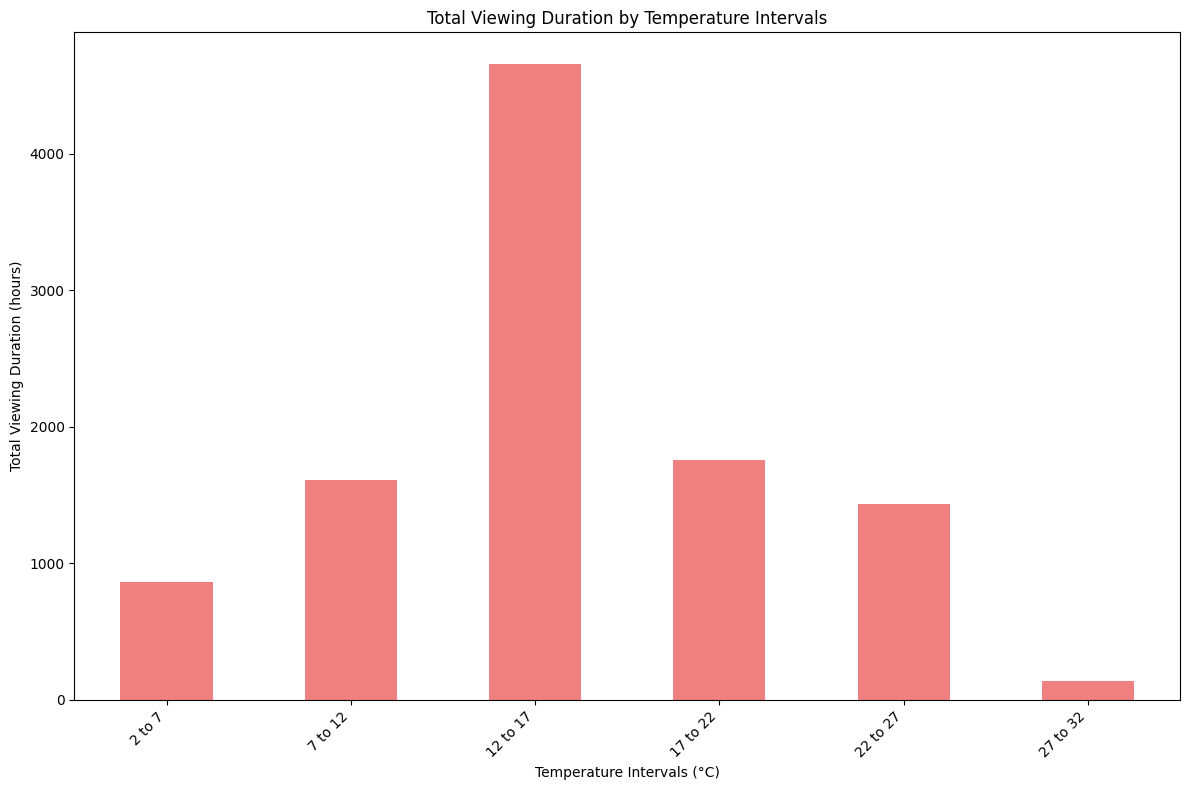

In [46]:
watching_by_temp = merged_data.groupby('temp_interval')['duration_minutes'].sum() / 60

plt.figure(figsize=(12, 8))
watching_by_temp.sort_index().plot(kind='bar', color='lightcoral')
plt.title('Total Viewing Duration by Temperature Intervals')
plt.ylabel('Total Viewing Duration (hours)')
plt.xlabel('Temperature Intervals (°C)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This bar chart visualizes the total viewing duration grouped by temperature intervals. We can see that between 12 and 17 Celsius dominates the chart since it is not normalized, but we will see that this time, it has nothing to do with normalization.

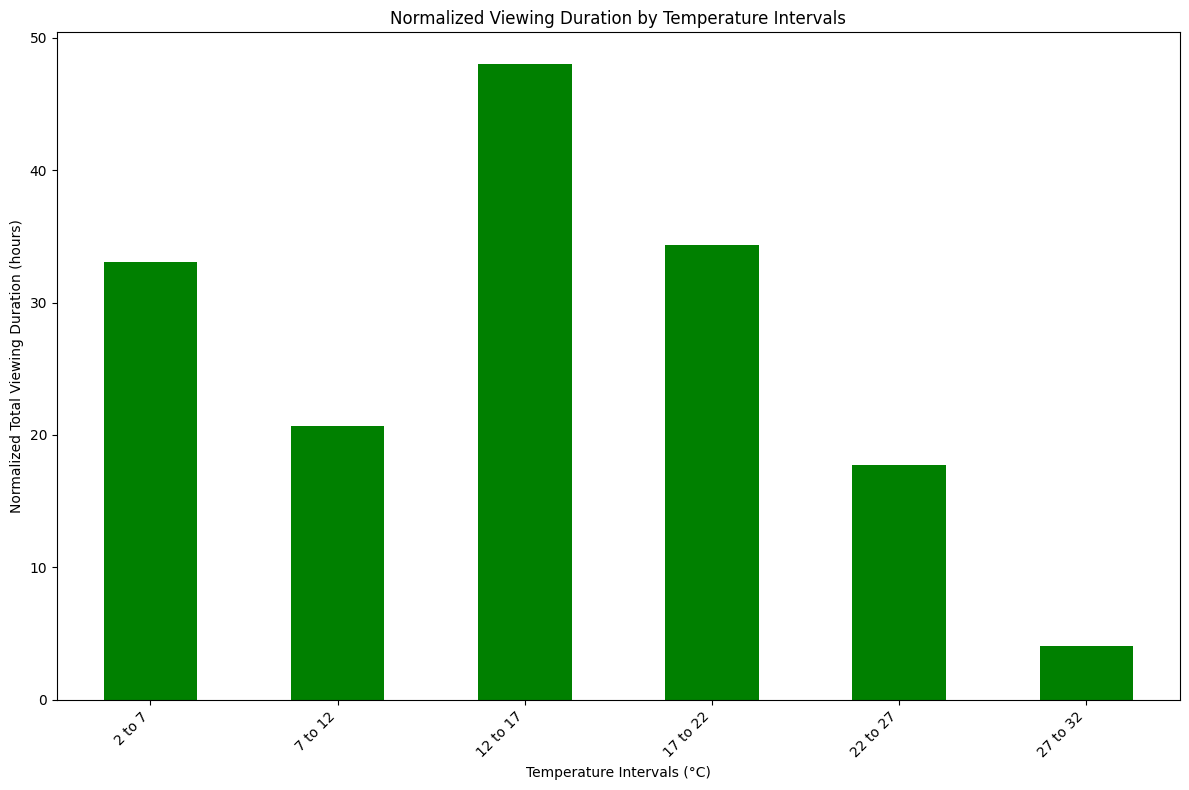

In [47]:
days_per_temp = weather_data['temp_interval'].value_counts()
normalized_temp = watching_by_temp / days_per_temp

plt.figure(figsize=(12, 8))
normalized_temp.sort_index().plot(kind='bar', color='green')
plt.title('Normalized Viewing Duration by Temperature Intervals')
plt.ylabel('Normalized Total Viewing Duration (hours)')
plt.xlabel('Temperature Intervals (°C)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

I normalized the data, and also, this time, 12 to 17 is the highest, but there is not a big difference this time. Looking at the chart, I can say that in cold temperatures, I prefer to stay at home and watch shows or movies.

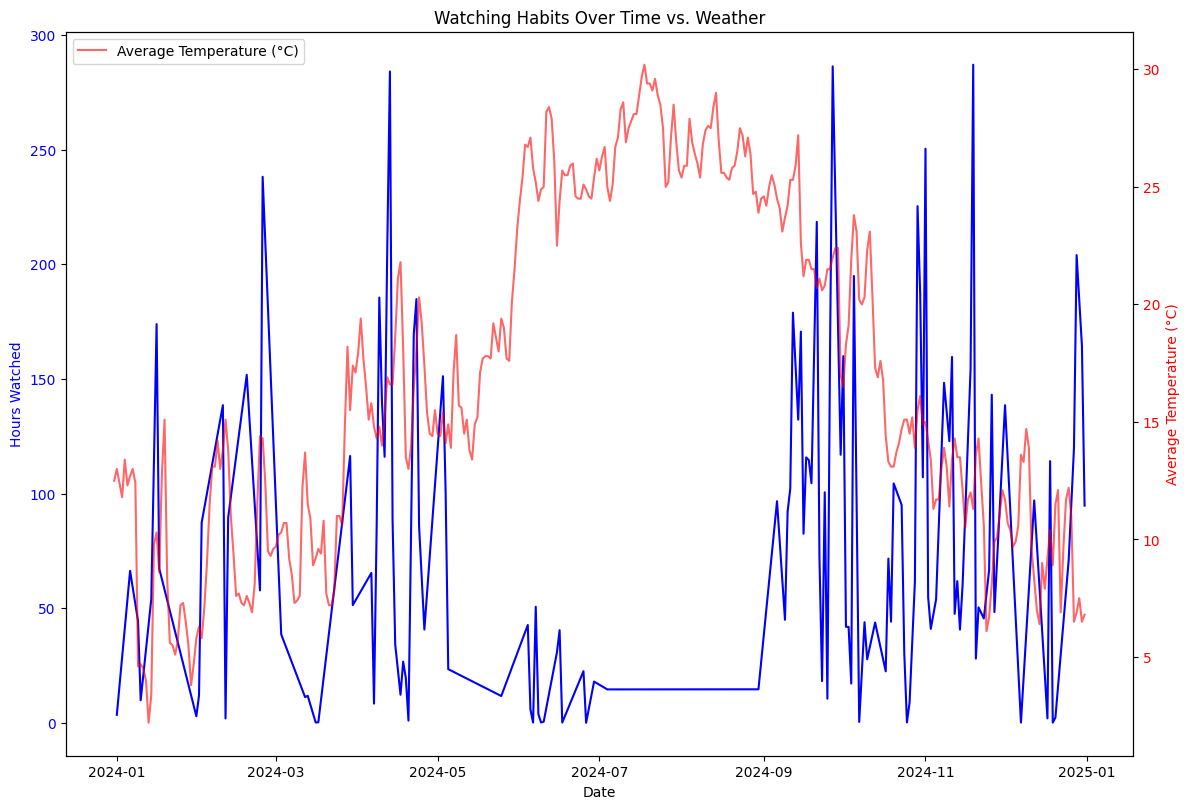

In [48]:
daily_viewing = merged_data.groupby('date')['duration_minutes'].sum()


daily_weather = weather_data.groupby('date').mean(numeric_only=True)


daily_viewing_hours = daily_viewing / 60

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(daily_viewing_hours.index, daily_viewing_hours.values, label='Hours Watched', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Hours Watched', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.plot(daily_weather.index, daily_weather['temp'], label='Average Temperature (°C)', color='red', alpha=0.6)
ax2.set_ylabel('Average Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.title('Watching Habits Over Time vs. Weather')
plt.legend(loc='upper left')
plt.show()

This line chart visualizes the relationship between viewing habits and weather over time. This is similar to the last one but I also added the date of the year below to see my activity during the year of the months and I can easily say that last summer was fun for me.

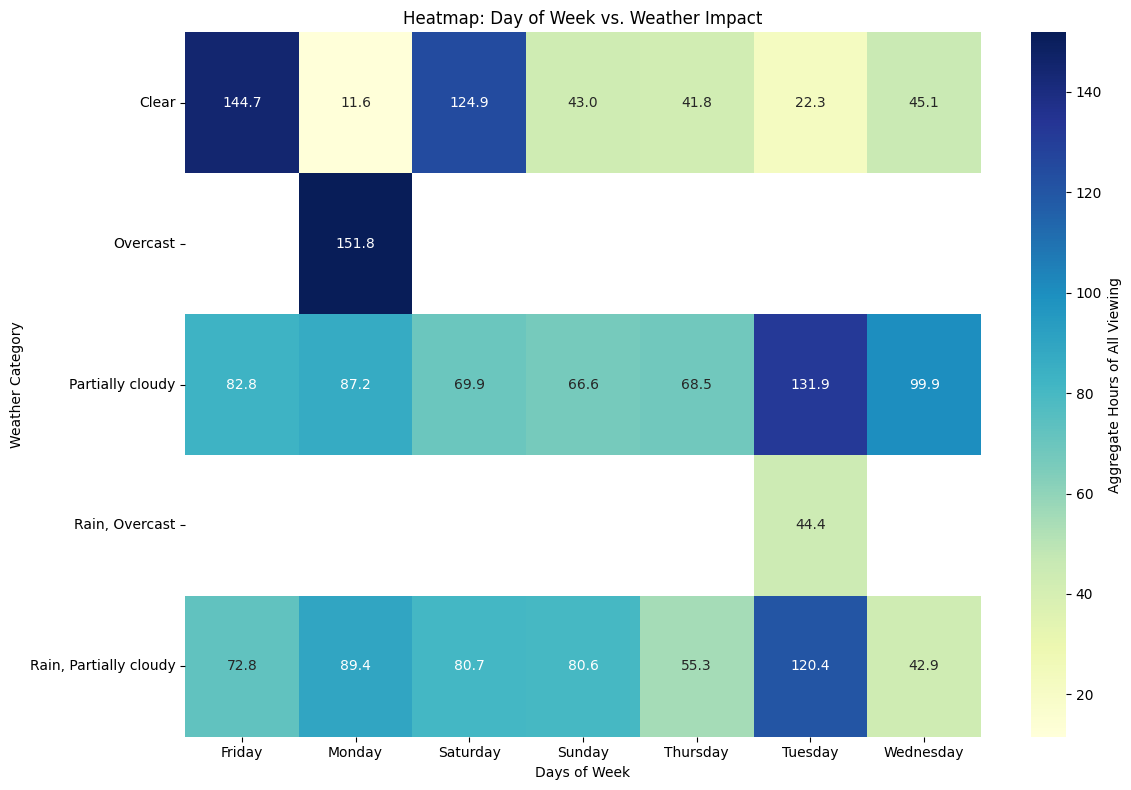

In [49]:

daily_totals = merged_data.groupby(['date', 'weather_category'], as_index=False)['duration_minutes'].sum()


daily_totals['day_of_week'] = pd.to_datetime(daily_totals['date']).dt.day_name()


heatmap_data = daily_totals.pivot_table(
    values='duration_minutes',
    index='weather_category',
    columns='day_of_week',
    aggfunc='mean'  
) / 60

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Aggregate Hours of All Viewing'})
plt.title('Heatmap: Day of Week vs. Weather Impact')
plt.xlabel('Days of Week')
plt.ylabel('Weather Category')
plt.tight_layout()
plt.show()

This heatmap visualizes the relationship between weather categories, days of the week, and the aggregate hours of all viewing (in hours). This plot is done to show all days and watching hours but I did not expect this since on weekdays I usually have school except Monday and Tuesday so having high watch hours on those days did not surprise me.

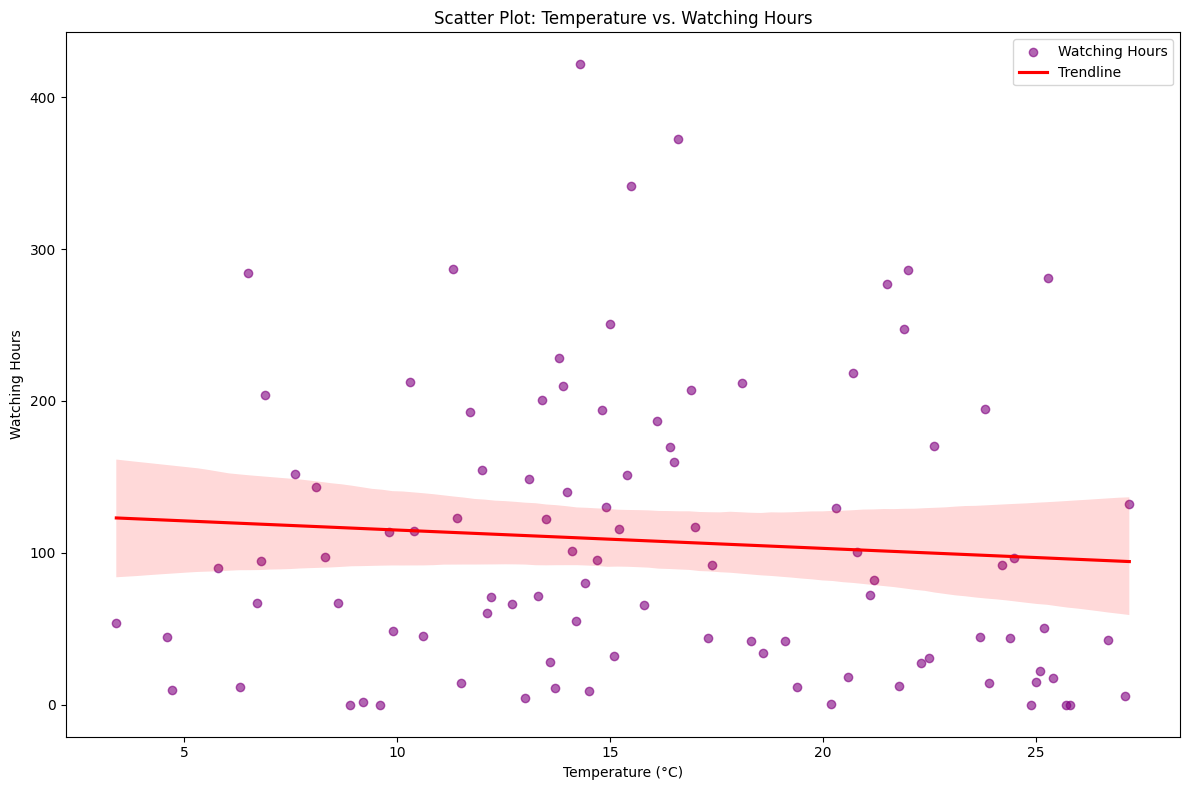

In [50]:
temp_vs_watching = merged_data.groupby('temp')['duration_minutes'].sum() / 60  

# Scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(temp_vs_watching.index, temp_vs_watching.values, alpha=0.6, color='purple', label='Watching Hours')
sns.regplot(x=temp_vs_watching.index, y=temp_vs_watching.values, scatter=False, color='red', label='Trendline')
plt.title('Scatter Plot: Temperature vs. Watching Hours')
plt.xlabel('Temperature (°C)')
plt.ylabel('Watching Hours')
plt.legend()
plt.tight_layout()
plt.show()


This scatter plot visualizes the relationship between temperature (in °C) and total viewing duration (in hours). This one is for the trendline which tells us when the temperature is getting higher I tend to watch less Netflix.